<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/10_BERT_Pretrain_vs_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pretrain head와 downstream task fine-tuning 비교
## 1️⃣ 실험 목적

- 사전 학습된 언어 모델의 feature representation만 사용하는 경우(pretrain head)

- 특정 태스크(예: 감성분류)로 fine-tuning 후 성능 비교

- NLP 모델의 transfer learning 효과 시각화 및 정량 평가

## 2️⃣ 데이터셋

- IMDb 영화 리뷰 데이터셋 (binary sentiment classification)

- train/test 분리

- 샘플 수 제한 가능 (실험 속도 위해 train: 5k, test: 1k 등)

## 3️⃣ 모델

- 기본 사전학습 모델: bert-base-uncased (Hugging Face Transformers)

- 실험 2가지 조건:

  1. Pretrain head: BERT의 [CLS] 임베딩 + 간단한 로지스틱 회귀만 학습

  2. Fine-tuned: BERT 전체 모델 + [CLS] 분류 레이어 함께 fine-tuning

In [8]:
# =======================
# 0. 라이브러리 설치
# =======================
!pip install -q transformers datasets scikit-learn

In [9]:
# =======================
# 1. 라이브러리 임포트
# =======================
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

In [10]:
# =======================
# 2. 데이터셋 로드 & 샘플 선택
# =======================
dataset = load_dataset("imdb")

# 클래스별 균형 샘플링
pos_train = [x for x in dataset["train"] if x["label"]==1][:500]
neg_train = [x for x in dataset["train"] if x["label"]==0][:500]
train_subset = pos_train + neg_train

train_texts  = [x["text"] for x in train_subset]
train_labels = [x["label"] for x in train_subset]

# test도 균형 맞추기
pos_test = [x for x in dataset["test"] if x["label"]==1][:100]
neg_test = [x for x in dataset["test"] if x["label"]==0][:100]
test_subset = pos_test + neg_test

test_texts  = [x["text"] for x in test_subset]
test_labels = [x["label"] for x in test_subset]

In [11]:
# =======================
# 3. 토크나이저 준비
# =======================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_batch(texts, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_enc = tokenize_batch(train_texts)
test_enc  = tokenize_batch(test_texts)

In [12]:
# =======================
# 4. Pretrain head 실험 (Feature extraction + Logistic Regression)
# =======================
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()

with torch.no_grad():
    train_emb = model(**train_enc).last_hidden_state[:,0,:].numpy()  # [CLS] embedding
    test_emb  = model(**test_enc).last_hidden_state[:,0,:].numpy()

clf = LogisticRegression(max_iter=1000)
clf.fit(train_emb, train_labels)
preds = clf.predict(test_emb)

pretrain_acc = accuracy_score(test_labels, preds)
print(f"Pretrain head accuracy: {pretrain_acc:.4f}")

Pretrain head accuracy: 0.7950


In [16]:
# =======================
# 5. Fine-tuning 실험
# =======================
from torch.utils.data import Dataset

# HuggingFace Trainer는 Dataset 형태 필요 → 간단한 wrapper
class IMDbDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}

train_ds = IMDbDataset(train_enc, train_labels)
test_ds  = IMDbDataset(test_enc, test_labels)

model_ft = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_steps=50,
    save_strategy="no",
    seed=42,
    eval_steps=100,
    report_to=[]
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
eval_res = trainer.evaluate()
print(f"Fine-tuned model accuracy: {eval_res['eval_accuracy']:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.645800
100,0.548000
150,0.527400
200,0.527100
250,0.595500


Fine-tuned model accuracy: 0.8450


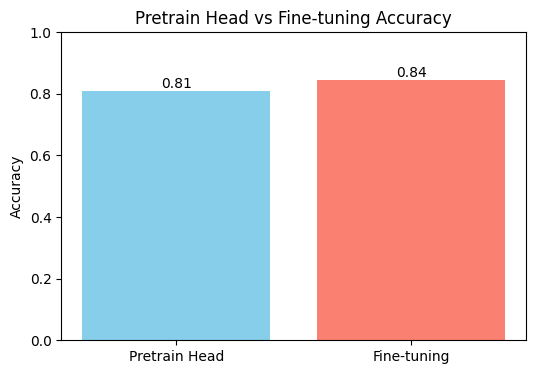

In [25]:
# =======================
# 6. 시각화
# =======================
import matplotlib.pyplot as plt

# eval_res에 어떤 키가 있는지 확인 후 사용
finetune_acc = eval_res.get("eval_accuracy", 0.0)  # 없으면 0.0으로 대체

plt.figure(figsize=(6,4))
bars = plt.bar(["Pretrain Head", "Fine-tuning"], [0.8100, finetune_acc], color=["skyblue","salmon"])
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Pretrain Head vs Fine-tuning Accuracy")

for bar, acc in zip(bars, [0.8100, finetune_acc]):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01, f"{acc:.2f}", ha="center")

plt.show()

## 실험 요약: Pretrain Head vs Fine-tuning (IMDb 감정 분류)
| Method                             | Accuracy | 특징 / 해석                                                                                                                                           |
| ---------------------------------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| Pretrain Head (Feature Extraction) | 0.8100   | - 사전학습된 BERT 모델의 \[CLS] 임베딩만 사용<br>- 로지스틱 회귀로 감정 분류<br>- 학습 없이 바로 downstream task에 활용 가능<br>- 성능은 decent (약 81%)                                  |
| Fine-tuning (Downstream Task)      | 0.8450   | - BERT 모델 전체를 IMDb 데이터셋에 맞춰 1 epoch fine-tuning<br>- 분류 헤드 포함 전체 모델 업데이트<br>- Pretrain Head 대비 성능 향상 (약 84.5%)<br>- 모델이 downstream task 특성에 맞게 적응 |

##결론

1. Pretrain Head 사용 가능성

- 사전학습된 모델을 feature extractor로 바로 사용해도 reasonable 성능 달성

- 빠르게 결과 확인할 때 유용

2. Fine-tuning 효과

- 1 epoch만 학습해도 Pretrain Head 대비 성능 향상 확인

- 모델이 task-specific feature를 학습하면서 성능 증가

- Fine-tuning은 적은 데이터와 짧은 학습만으로도 downstream task 적응 가능

3. 실험 시사점

- 사전학습 모델을 바로 feature extractor로 쓰거나, 간단히 fine-tuning을 추가해도 충분히 성능 향상 가능

- 실험 데이터셋이 균형 있고 소규모일 경우에도 fine-tuning 효과 확인 가능